In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

from legwork import evol, utils
import legwork.strain as strain
import legwork

from astropy.constants import G
from astropy.constants import c
import astropy.units as u
from astropy.visualization import quantity_support
quantity_support()

import random

from joblib import Parallel, delayed
import os


## Source load

In [ ]:
df10 = pd.read_csv("data/selected_emri_moments10.csv")
a10 = df10['a (pc)']
ecc10 = df10['e']
f_orb10 = df10['f_orb']
delta_f_orb10 = df10['delta_f_orb']
t10 = df10['time']

df10_2_1200 = pd.read_csv("data/selected_emri_moments10_2_1200.csv")
a10_2_1200 = df10_2_1200['a (pc)']
ecc10_2_1200 = df10_2_1200['e']
f_orb10_2_1200 = df10_2_1200['f_orb']
delta_f_orb10_2_1200 = df10_2_1200['delta_f_orb']
t10_2_1200 = df10_2_1200['time']

df10_25_1200 = pd.read_csv("data/selected_emri_moments10_2.5_1200.csv")
a10_25_1200 = df10_25_1200['a (pc)']
ecc10_25_1200 = df10_25_1200['e']
f_orb10_25_1200 = df10_25_1200['f_orb']
delta_f_orb10_25_1200 = df10_25_1200['delta_f_orb']
t10_25_1200 = df10_25_1200['time']

df10_3_1200 = pd.read_csv("data/selected_emri_moments10_3_1200.csv")
a10_3_1200 = df10_3_1200['a (pc)']
ecc10_3_1200 = df10_3_1200['e']
f_orb10_3_1200 = df10_3_1200['f_orb']
delta_f_orb10_3_1200 = df10_3_1200['delta_f_orb']
t10_3_1200 = df10_3_1200['time']

df10_35_1200 = pd.read_csv("data/selected_emri_moments10_3.5_1200.csv")
a10_35_1200 = df10_35_1200['a (pc)']
ecc10_35_1200 = df10_35_1200['e']
f_orb10_35_1200 = df10_35_1200['f_orb']
delta_f_orb10_35_1200 = df10_35_1200['delta_f_orb']
t10_35_1200 = df10_35_1200['time']

In [ ]:

e_band_10 =0.9985615916890163
e_thr_10 =0.35151889190920926
e_min_10 =0.04441115572848246
n2_10 = 2.8
n1_10 =0.005

e_band_10_35_1200 =0.9978848710195648
e_thr_10_35_1200 =0.3511227010860089
e_min_10_35_1200 =0.2
n2_10_35_1200 =0.57
n1_10_35_1200 =0.0003

e_band_10_3_1200 =0.997888368675415
e_thr_10_3_1200 =0.35046399106891774
e_min_10_3_1200 =0.2
n2_10_3_1200 =1.8
n1_10_3_1200 =0.002


e_band_10_25_1200 =0.9978916878563417
e_thr_10_25_1200 =0.3487549494956626
e_min_10_25_1200 =0.2
n2_10_25_1200 =2
n1_10_25_1200 =0.003

e_band_10_2_1200 =0.99788874227005
e_thr_10_2_1200 =0.348678916089257
e_min_10_2_1200 =0.2
n2_10_2_1200 =2.1
n1_10_2_1200 =0.003

In [5]:
sources10 = [
    {'ecc': e, 'f_orb': f_orb, 'delta_f_orb': delta_f_orb, 'time': t}
    for e, f_orb, delta_f_orb, t in zip(ecc10, f_orb10, delta_f_orb10, t10)
]

sources10_2_1200 = [
    {'ecc': e, 'f_orb': f_orb, 'delta_f_orb': delta_f_orb, 'time': t}
    for e, f_orb, delta_f_orb, t in zip(ecc10_2_1200, f_orb10_2_1200, delta_f_orb10_2_1200, t10_2_1200)
]

sources10_25_1200 = [
    {'ecc': e, 'f_orb': f_orb, 'delta_f_orb': delta_f_orb, 'time': t}
    for e, f_orb, delta_f_orb, t in zip(ecc10_25_1200, f_orb10_25_1200, delta_f_orb10_25_1200, t10_25_1200)
]

sources10_3_1200 = [
    {'ecc': e, 'f_orb': f_orb, 'delta_f_orb': delta_f_orb, 'time': t}
    for e, f_orb, delta_f_orb, t in zip(ecc10_3_1200, f_orb10_3_1200, delta_f_orb10_3_1200, t10_3_1200)
]

sources10_35_1200 = [
    {'ecc': e, 'f_orb': f_orb, 'delta_f_orb': delta_f_orb, 'time': t}
    for e, f_orb, delta_f_orb, t in zip(ecc10_35_1200, f_orb10_35_1200, delta_f_orb10_35_1200, t10_35_1200)
]


## Parameters

In [ ]:
m_1 = 10* u.Msun
m_2 =  4.3*10**6 * u.Msun
mu = m_1 * m_2 / (m_1 + m_2)
M = m_1 + m_2
m_c = utils.chirp_mass(m_1, m_2)

ecc_i = 0.9997
a_i = 0.01 * u.pc
f_orb_i = utils.get_f_orb_from_a(a =a_i, m_1=m_1, m_2=m_2)

dist = 8 * u.kpc
t_obs = 1 * u.yr

# calculate other params
beta = utils.beta(m_1=m_1, m_2=m_2)
c_0 = utils.c_0(a_i, ecc_i)

t_merge = evol.get_t_merge_ecc(ecc_i, a_i=a_i, f_orb_i=f_orb_i, beta=beta, m_1=m_1, m_2=m_2, small_e_tol=0.05, large_e_tol=0.9999, exact=True)
t_merge = t_merge.to(u.yr)

evol.check_mass_freq_input(beta=beta, m_1=m_1, m_2=m_2, a_i=a_i, f_orb_i=f_orb_i)
delta_f = 1e-5 * u.Hz               
f_min = 1e-5 * u.Hz                 
f_max = 1e-1 * u.Hz                 

bin_frequencies = np.arange(f_min.to_value(u.Hz), f_max.to_value(u.Hz), delta_f.to_value(u.Hz)) * u.Hz

## Characteristic strain

In [7]:
def calculate_h2_c_gwb_multiple_bins(h_m_n,h_c_m_n, f_m_n, T_obs, delta_f_mn, delta_f, bin_frequencies,f_m_n_dot):
    bin_contributions = {}

    factor = f_m_n / (f_m_n_dot * T_obs)

    if factor < 1:
        h2_c_gwb = (h_c_m_n**2 / (2 * f_m_n * T_obs)).to_value(u.dimensionless_unscaled)  # 转换为无单位
                   
    else:
        
        h2_c_gwb = ((h_m_n**2) / (2)) 

    if delta_f_mn > delta_f:

        f_min = f_m_n
        f_max = f_m_n + delta_f_mn

        
        for bin_freq in bin_frequencies:
            if f_min <= bin_freq <= f_max:  
                bin_contributions[bin_freq] = h2_c_gwb  
                
    else:

        closest_bin = min(bin_frequencies, key=lambda x: abs(x - f_m_n))
        bin_contributions[closest_bin] = h2_c_gwb

    return bin_contributions


def compute_h_gwb_bins(sourcess1, T_obs, delta_f, f_min, f_max, bin_frequencies):
    
    h_gwb_bins = np.zeros(len(bin_frequencies))

    f_orb_m = sourcess1['f_orb'] * u.Hz  
    delta_f_orb_m = sourcess1['delta_f_orb'] * u.Hz  
    ecc_m = sourcess1['ecc']
 
    n = 1
    while n < 1000:
        f_m_n = n * f_orb_m 
        if f_m_n > f_max:  
            break
        if f_m_n < f_min:
            n += 1  
            continue
            
        h_c_m_n = strain.h_c_n(m_c=m_c, f_orb=f_orb_m, ecc=ecc_m, n=n, dist=dist).flatten()
        h_m_n = strain.h_0_n(m_c=m_c, f_orb=f_orb_m, ecc=ecc_m, n=n, dist=dist).flatten()
        f_m_n_dot = legwork.utils.fn_dot(m_c, f_orb_m, ecc_m, n)

            
        delta_f_mn = n * delta_f_orb_m

            
        bin_contributions = calculate_h2_c_gwb_multiple_bins(
            h_m_n, h_c_m_n, f_m_n, T_obs, delta_f_mn, delta_f, bin_frequencies,f_m_n_dot
        )

            
        for bin_freq, contribution in bin_contributions.items():
                
            bin_index = np.where(bin_frequencies == bin_freq)[0][0]
            h_gwb_bins[bin_index] += contribution

        n += 1  
    print(n)

    return h_gwb_bins

In [43]:
import math
def convert_to_integer(decimal):
    if decimal == 0:
        return 0, 1
    factor = 1
    while True:
        # 四舍五入到最接近的整数
        integer_candidate = round(decimal)
        # 检查是否足够接近整数
        if math.isclose(decimal, integer_candidate, abs_tol=1e-10):
            decimal = integer_candidate
            break
        decimal *= 10
        factor *= 10
    return int(decimal), factor

In [9]:
def hgw(e_band, e_thr, e_min, n2, n1,sources11):

    sources_tt = [source['time'] for source in sources11 if  e_thr <= source['ecc'] < e_band]
    t_b = np.max(sources_tt) - np.min(sources_tt)

    n2,k2 = convert_to_integer(n2)
    n1,k1 = convert_to_integer(n1)

    print(k1,k2)

    selection_conditions = [
    {'ecc_min': e_thr, 'ecc_max':0.5},
    {'ecc_min': 0.5, 'ecc_max': 0.8},
    {'ecc_min': 0.8, 'ecc_max': 0.9},
    {'ecc_min': 0.9, 'ecc_max': 0.99},
    {'ecc_min': 0.99, 'ecc_max': e_band}
    ]

    selected_sources = []

    for condition in selection_conditions:
        ecc_min = condition['ecc_min']
        ecc_max = condition['ecc_max']
    
  
        filtered_sources = [source for source in sources11 if ecc_min <= source['ecc'] < ecc_max]
        sources_t = [source['time'] for source in filtered_sources]
    
        if len(filtered_sources) > 1:
        
            t_interval = np.max(sources_t) - np.min(sources_t)
            sample_size = int(np.round(n2  * t_interval / t_b))
        
            print(n2  *t_interval/t_b)
            print("数量:", len(filtered_sources))
            print(sample_size)

        
            if sample_size > len(filtered_sources):
                num_new_points = sample_size - len(filtered_sources)
            
           
                time_values = np.array(sources_t)
                ecc_values = np.array([source['ecc'] for source in filtered_sources])
                f_orb_values = np.array([source['f_orb'] for source in filtered_sources])
                delta_f_orb_values = np.array([source['delta_f_orb'] for source in filtered_sources])
            
            
                ecc_interp = interp1d(time_values, ecc_values, kind='linear', fill_value="extrapolate")
                f_orb_interp = interp1d(time_values, f_orb_values, kind='linear', fill_value="extrapolate")
                delta_f_orb_interp = interp1d(time_values, delta_f_orb_values, kind='linear', fill_value="extrapolate")
            
            
                new_times = np.linspace(np.min(sources_t), np.max(sources_t), sample_size)
            
            
                new_eccs = ecc_interp(new_times)
                new_f_orbs = f_orb_interp(new_times)
                new_delta_f_orbs = delta_f_orb_interp(new_times)
            
            
                for t, ecc, f_orb, delta_f_orb in zip(new_times, new_eccs, new_f_orbs, new_delta_f_orbs):
                    filtered_sources.append({'time': t, 'ecc': ecc, 'f_orb': f_orb, 'delta_f_orb': delta_f_orb})
        
    
        selected_sources.extend(random.sample(filtered_sources, sample_size))

    print("筛选出的源数量:", len(selected_sources))
    print("选中的源:", selected_sources)




    selected_sources_ = []
    required = int(n1)
    filtered_sources = [source for source in sources11 if e_min <= source['ecc'] < e_thr]
    available = len(filtered_sources)

    if available == 0:
        raise ValueError("指定偏心率范围内没有符合条件的源")

    # 根据可用源数量动态选择抽样方式
    if available >= required:
        # 数量充足：无放回随机抽样
        selected_sources1 = random.sample(filtered_sources, required)
    else:
        # 数量不足：有放回随机抽样（允许重复）
        selected_sources1 = random.choices(filtered_sources, k=required)

    selected_sources_.extend(selected_sources1)

    print(f"最终选中的源数量: {len(selected_sources_)}")
    print(f"选中的源示例: {selected_sources_[:3]}")


    result = Parallel(n_jobs=-1)(
    delayed(compute_h_gwb_bins)(sources, t_obs, delta_f, f_min, f_max, bin_frequencies)
    for sources in selected_sources
    )

    result_ = Parallel(n_jobs=-1)(
    delayed(compute_h_gwb_bins)(sources, t_obs, delta_f, f_min, f_max, bin_frequencies)
    for sources in selected_sources_
    )

    h_gwb_bins_total0 = np.sum(result, axis=0)
    h_gwb_bins_total_ = np.sum(result_, axis=0)
    h_gwb_bins_total = h_gwb_bins_total_/k1 + h_gwb_bins_total0/k2

    return h_gwb_bins_total
    

## Strain calculation

In [ ]:
h1 = []
for i in range(0,20):
    b_i = hgw(e_band_10_2_1200, e_thr_10_2_1200, e_min_10_2_1200, n2_10_2_1200, n1_10_2_1200,sources10_2_1200)
    h1.append(b_i)
    print(b_i)

a1 = np.sum(h1,axis=0)/20

hc10_2_1200 = pd.DataFrame({
        'hc':(a1)**(1/2),

        'f':bin_frequencies
})

hc10_2_1200.to_csv('data/hcgwb10_2_1200.csv',index=False)

1000 10
0.07662381362300699
数量: 40
0
0.5874492377763869
数量: 66
1
0.8448266630228976
数量: 44
1
7.072148339141114
数量: 55
7
12.181221652888292
数量: 63
12
筛选出的源数量: 21
选中的源: [{'ecc': 0.5314711859755664, 'f_orb': 5.839444946058264e-05, 'delta_f_orb': 5.564773891233082e-08, 'time': 295365.8310850359}, {'ecc': 0.8349368046638569, 'f_orb': 9.653678935232884e-06, 'delta_f_orb': 2.7101148298898932e-09, 'time': 291395.8310850359}, {'ecc': 0.9357007831551512, 'f_orb': 2.2166267889441947e-06, 'delta_f_orb': 3.3103290789664703e-10, 'time': 284000.0}, {'ecc': 0.979158031474042, 'f_orb': 4.0013161607417357e-07, 'delta_f_orb': 3.201642050700695e-11, 'time': 268000.0}, {'ecc': 0.9509387570741052, 'f_orb': 1.465835826516738e-06, 'delta_f_orb': 1.8710660614549983e-10, 'time': 281000.0}, {'ecc': 0.9093900529793788, 'f_orb': 3.760951145588419e-06, 'delta_f_orb': 6.934442655293583e-10, 'time': 287195.8310850359}, {'ecc': 0.9722815842505368, 'f_orb': 6.157802501835657e-07, 'delta_f_orb': 5.7346698059726894e-11, 

In [ ]:
h2 = []
for i in range(0,20):
    b_i = hgw(e_band_10_25_1200, e_thr_10_25_1200, e_min_10_25_1200, n2_10_25_1200, n1_10_25_1200, sources10_25_1200)
    h2.append(b_i)
    print(b_i)

a2 = np.sum(h2,axis=0)/20

hc10_25_1200 = pd.DataFrame({
        'hc':(a2)**(1/2),

        'f':bin_frequencies
})

hc10_25_1200.to_csv('data/hcgwb10_2.5_1200.csv',index=False)

1000 1
0.0070550288746556
数量: 38
0
0.05567752517295771
数量: 68
0
0.07817734698942692
数量: 42
0
0.67289186574046
数量: 57
1
1.1631263820378153
数量: 62
1
筛选出的源数量: 2
选中的源: [{'ecc': 0.9138737030811088, 'f_orb': 3.510160462578478e-06, 'delta_f_orb': 6.463830204730553e-10, 'time': 284089.71953869204}, {'ecc': 0.9975662450362252, 'f_orb': 1.6086858835965014e-08, 'delta_f_orb': 4.511024569281197e-13, 'time': 195000.0}]
最终选中的源数量: 3
选中的源示例: [{'ecc': 0.2234495885383517, 'f_orb': 0.00021640335839, 'delta_f_orb': 1.566189410257354e-06, 'time': 293028.71953869204}, {'ecc': 0.2356351457051689, 'f_orb': 0.0002037083018306, 'delta_f_orb': 1.2987310905797583e-06, 'time': 293019.71953869204}, {'ecc': 0.3287773188358955, 'f_orb': 0.0001347244428563, 'delta_f_orb': 3.9501310846265123e-07, 'time': 292919.71953869204}]
[2.04963870e-38 1.06867516e-38 1.73934283e-38 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1000 1
0.0070550288746556
数量: 38
0
0.05567752517295771
数量: 68
0
0.07817734698942692
数量: 42
0
0.67289

In [ ]:
h3 = []
for i in range(0,20):
    b_i = hgw(e_band_10_3_1200, e_thr_10_3_1200, e_min_10_3_1200, n2_10_3_1200, n1_10_3_1200, sources10_3_1200)
    h3.append(b_i)
    print(b_i)

a3 = np.sum(h3,axis=0)/20

hc10_3_1200 = pd.DataFrame({
        'hc':(a3)**(1/2),

        'f':bin_frequencies
})

hc10_3_1200.to_csv('data/hcgwb10_3_1200.csv',index=False)

1000 10
0.04819955037044431
数量: 26
0
0.44150788139326985
数量: 77
0
0.6747937051862203
数量: 36
1
5.998311957759367
数量: 65
6
10.603901081497748
数量: 56
11
筛选出的源数量: 18
选中的源: [{'ecc': 0.8906057885501849, 'f_orb': 5.198745877361505e-06, 'delta_f_orb': 1.325370029761997e-09, 'time': 255711.86676876916}, {'ecc': 0.9745978134514204, 'f_orb': 5.438767241876792e-07, 'delta_f_orb': 5.578088538681747e-11, 'time': 241000.0}, {'ecc': 0.9790391622396803, 'f_orb': 4.0627263801554923e-07, 'delta_f_orb': 3.7500842087098216e-11, 'time': 238000.0}, {'ecc': 0.911252394338556, 'f_orb': 3.735077375688677e-06, 'delta_f_orb': 8.199096028623239e-10, 'time': 254311.86676876916}, {'ecc': 0.9321804027714768, 'f_orb': 2.4533146999588654e-06, 'delta_f_orb': 4.499021916534823e-10, 'time': 252211.86676876916}, {'ecc': 0.9124763943386976, 'f_orb': 3.654378491293025e-06, 'delta_f_orb': 7.9450366142656e-10, 'time': 254211.86676876916}, {'ecc': 0.959855724035486, 'f_orb': 1.0929425511532048e-06, 'delta_f_orb': 1.453348024126

In [ ]:
h4 = []
for i in range(0,20):
    b_i = hgw(e_band_10_35_1200, e_thr_10_35_1200, e_min_10_35_1200, n2_10_35_1200, n1_10_35_1200,sources10_35_1200)
    h4.append(b_i)
    print(b_i)

a4 = np.sum(h4,axis=0)/20

hc10_35_1200 = pd.DataFrame({
        'hc':(a4)**(1/2),

        'f':bin_frequencies
})

hc10_35_1200.to_csv('data/hcgwb10_3.5_1200.csv',index=False)

10000 100
0.11236302519131498
数量: 58
0
1.2773901811223176
数量: 82
1
2.089558012329717
数量: 35
2
17.818815987674096
数量: 83
18
33.51177944302377
数量: 18
34
筛选出的源数量: 55
选中的源: [{'ecc': 0.5397162881597677, 'f_orb': 8.23889868136169e-05, 'delta_f_orb': 5.585980914067943e-07, 'time': 81829.205820314}, {'ecc': 0.8473295555992796, 'f_orb': 9.15127701543553e-06, 'delta_f_orb': 1.042578662328674e-08, 'time': 80839.205820314}, {'ecc': 0.8341243094216487, 'f_orb': 1.0550814882745565e-05, 'delta_f_orb': 1.3064255932356656e-08, 'time': 80959.205820314}, {'ecc': 0.9508565680353688, 'f_orb': 1.4820283938122262e-06, 'delta_f_orb': 7.139591865956135e-10, 'time': 78239.205820314}, {'ecc': 0.9588461900063964, 'f_orb': 1.1273673796174065e-06, 'delta_f_orb': 4.873880301575767e-10, 'time': 77639.205820314}, {'ecc': 0.9763092120231148, 'f_orb': 4.850828802346525e-07, 'delta_f_orb': 1.5274750140287055e-10, 'time': 75339.205820314}, {'ecc': 0.9815828983726615, 'f_orb': 3.311352637831469e-07, 'delta_f_orb': 9.090808

C:\Users\fengchen\AppData\Local\Temp\ipykernel_50112\1257795716.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


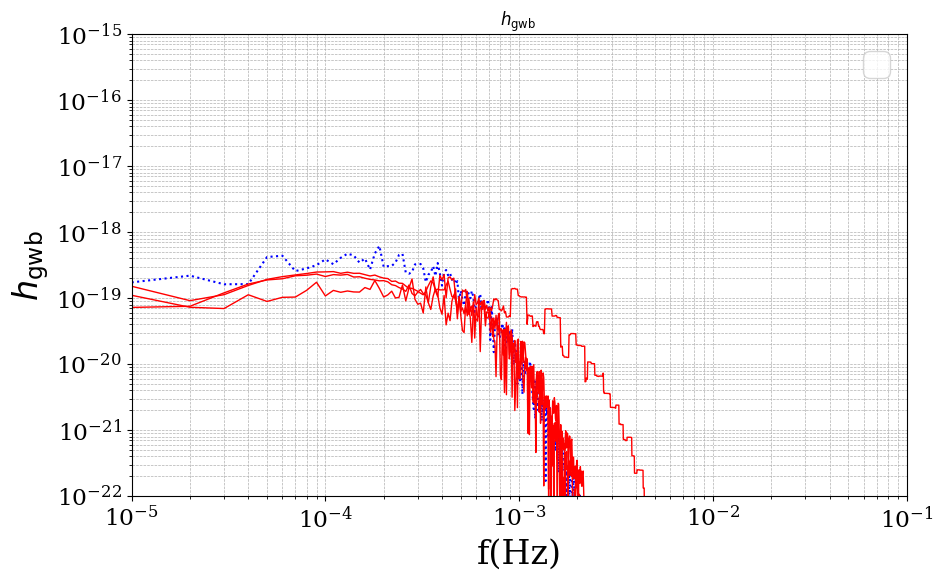

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(bin_frequencies, (a1)**(1/2), color='b',linestyle=':')
plt.plot(bin_frequencies, (a2)**(1/2), color='r',linewidth=1 )
plt.plot(bin_frequencies, (a3)**(1/2), color='r',linewidth=1 )
plt.plot(bin_frequencies, (a4)**(1/2), color='r',linewidth=1 )
plt.ylim(10**(-22), 10**(-15))
plt.xlim(10**(-5), 10**(-1))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f(Hz)')
plt.ylabel(r'$h_{\text{gwb}}$')
plt.title(r'$h_{\text{gwb}}$ ')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()